In [1]:
import torch
from main_dc import *
from nice import NICE
import numpy as np
from sklearn.cluster import KMeans
from gmeans import GMeans
import warnings, pickle
# debug
torch.__version__

2022-02-14 20:18:05.916680: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


'1.7.1'

## KMeans baseline

In [2]:
ds_name, n_sample = 'mnist', 60000
ae_data, ds_ae = load_ae_dataset(ds_name, n_sample, './saved_ae/mnist/mnist_ae_feat.pt')
repr_name = 'ae repr'
results_all = {}
for priorK in [8, 10, 15, 23]:
    kmeans_ks = KMeans(n_clusters=priorK, random_state=0, max_iter=300).fit(ae_data).labels_
    kmeans_results = eval_cluster(kmeans_ks, ds_ae.targets, return_extra=True, alg=f'{priorK}+Means+{repr_name}', ds_name=ds_name)
    results_all[f'kmeans{priorK}'] = kmeans_results[:-1]
df = pd.DataFrame(results_all).T
df.columns = 'F score | V score | ARI | NMI | ACC* | K | wEntropy'.split(' | ')

start loading ae dataset
tensor(4.1634)
tensor(13.0933)


## Evaluation

In [3]:
from jack_utils import NamedDict
# raw labels
exp_info = NamedDict({
    'VaDE_har': dict(nclass=6,
                     nsample=10200,
                     best_dpm='exp_out/har/full_har_VaDE_har_N10200_E5_kappa0_0.005_a0_600_b0_100_alpha_1e-10_20220211-182040_p787/dpm_E0.npz',
                     best_ddpm='exp_out/har/full_har_VaDE_har_N10200_E5_kappa0_0.005_a0_600_b0_100_alpha_1e-10_20220211-182040_p787/dpm_E4.npz',
                     best_ddpm_flow='exp_out/har/full_har_VaDE_har_N10200_E5_kappa0_0.005_a0_600_b0_100_alpha_1e-10_20220211-182040_p787/flow_E4.pt'),
    'VaDE_reuters10k': dict(nclass=4,
                            nsample=10000,
                     best_dpm='exp_out/reuters/full_reuters_VaDE_reuters10k_N10000_E5_kappa0_0.005_a0_600_b0_100_alpha_1e-10_20220211-174651_p32574/dpm_E0.npz',
                     best_ddpm='exp_out/reuters/full_reuters_VaDE_reuters10k_N10000_E5_kappa0_0.005_a0_600_b0_100_alpha_1e-10_20220211-174651_p32574/dpm_E4.npz',
                     best_ddpm_flow='exp_out/reuters/full_reuters_VaDE_reuters10k_N10000_E5_kappa0_0.005_a0_600_b0_100_alpha_1e-10_20220211-174651_p32574/flow_E4.pt'),
    'VaDE_stl': dict(nclass=10,
                     nsample=13000,
                     best_dpm='exp_out/stl/full_stl_VaDE_stl_N13000_E5_kappa0_0.005_a0_1000_b0_100_alpha_1e-10_20220212-104750_p14565/dpm_E0.npz',
                     best_ddpm='exp_out/stl/full_stl_VaDE_stl_N13000_E5_kappa0_0.005_a0_1000_b0_100_alpha_1e-10_20220212-104750_p14565/dpm_E4.npz',
                     best_ddpm_flow='exp_out/stl/full_stl_VaDE_stl_N13000_E5_kappa0_0.005_a0_1000_b0_100_alpha_1e-10_20220212-104750_p14565/flow_E4.pt'),
    'mnist': dict(nclass=10,
                  nsample=60000,
                  best_dpm='./exp_out/mnist/full_mnist_mnist_N60000_E5_kappa0_0.005_a0_200_b0_100_alpha_0.001_20220212-175824_p23354/dpm_E0.npz',
                  best_ddpm='./exp_out/mnist/full_mnist_mnist_N60000_E5_kappa0_0.005_a0_200_b0_100_alpha_0.001_20220212-175824_p23354/dpm_E4.npz',
                  best_ddpm_flow='./exp_out/mnist/full_mnist_mnist_N60000_E5_kappa0_0.005_a0_200_b0_100_alpha_0.001_20220212-175824_p23354/flow_E4.pt'),
})
     
    
def eval_ds(ds_name, info):
    # load data
    info = exp_info[ds_name]
    ds_ae_repr, ds_ae = load_ae_dataset(ds_name, info.nsample, './saved_ae/mnist/mnist_ae_feat.pt')
    print(ds_ae.data.shape, ds_ae.ae_x.shape, ds_ae.targets.shape)
    repr_list = [(f'{ds_name} ae repr', get_flow_repr(ds_ae_repr, None))]
    
    model_nice = NICE(data_dim=10, num_coupling_layers=6)
    model_nice.load_state_dict(torch.load(info.best_ddpm_flow, map_location='cpu'))
    repr_list.append((f'{ds_name} flow repr', get_flow_repr(ds_ae_repr, model_nice, normalize=False)))
    print([[k, v.shape] for k,v in repr_list])
    
    # eval alg
    results_all = {}
    # dpm
    dpm_result = np.load(info.best_dpm)
    K, ks, ns, mu_K, lam_K = dpm_result['K'], dpm_result['ks'], dpm_result['ns'], dpm_result['mu_K'], dpm_result['lam_K']
    dpm_results = eval_cluster(ks, ds_ae.targets, return_extra=True, alg='DPM', ds_name=ds_name)
    dpm_final_K = dpm_results[-3]
    results_all[f'DPM+ae'] = dpm_results[:-1]

    # ddpm
    ddpm_result = np.load(info.best_ddpm)
    K, ks, ns, mu_K, lam_K = ddpm_result['K'], ddpm_result['ks'], ddpm_result['ns'], ddpm_result['mu_K'], ddpm_result['lam_K']
    ddpm_results = eval_cluster(ks, ds_ae.targets, return_extra=True, alg='DDPM', ds_name=ds_name)
    ddpm_final_K = ddpm_results[-3]
    results_all['DDPM'] = ddpm_results[:-1]
    
    # kmeans
    for repr_name, repr_data in repr_list:
        for priorK in [dpm_final_K, ddpm_final_K, info.nclass, info.nclass//2, info.nclass*2][:3]:
            kmeans_ks = KMeans(n_clusters=priorK, random_state=0, max_iter=300).fit(repr_data).labels_
            kmeans_results = eval_cluster(kmeans_ks, ds_ae.targets, return_extra=True, alg=f'{priorK}+Means+{repr_name}', ds_name=ds_name)
            results_all[f'{priorK}-means+{repr_name}'] = kmeans_results[:-1]
        print()
        
    # gmeans
    warnings.filterwarnings('ignore')
    for repr_name, repr_data in repr_list:
        for max_depth in [100]:
            gm = GMeans(max_depth=max_depth)
            gm.fit(repr_data.cpu().numpy())
            gm_results = eval_cluster(gm.labels_, ds_ae.targets, return_extra=True, ds_name=ds_name, alg=f'GMeans+{repr_name}')
            gm_final_K = gm_results[-3]
            results_all[f'G-means({max_depth})+{repr_name}'] = gm_results[:-1]
        print()
        
    import pandas as pd
    import pickle
    df = pd.DataFrame(results_all).T
    df.columns = 'F score | V score | ARI | NMI | ACC* | K | wEntropy'.split(' | ')
    pickle.dump(df.T, open(f'{ds_name}.result', 'wb'))
    return df.T

def df2latex(df):
    print('Dataset & Metrics &', ' & '.join(df.columns), '\\\\')
    for i in range(df.shape[0]):
        print('ds_name &', ' & '.join([str(df.index[i])] + ['%.4f' % x for x in df.iloc[i].values]), '\\\\')

In [4]:
eval_from_load = False
df_dict = {}
for ds_name in ['mnist', 'VaDE_har', 'VaDE_reuters10k', 'VaDE_stl']:
    if eval_from_load:
        df_dict[ds_name] = pickle.load(open(f'{ds_name}.result', 'rb'))
    else:
        df_dict[ds_name] = eval_ds(ds_name, exp_info[ds_name])

start loading ae dataset
tensor(4.1634)
tensor(13.0933)
torch.Size([60000, 28, 28]) torch.Size([60000, 10]) torch.Size([60000])
[['mnist ae repr', torch.Size([60000, 10])], ['mnist flow repr', torch.Size([60000, 10])]]




start loading ae dataset
(10200, 561) torch.Size([10200, 10]) (10200,)
[['VaDE_har ae repr', torch.Size([10200, 10])], ['VaDE_har flow repr', torch.Size([10200, 10])]]




start loading ae dataset
(10000, 2000) torch.Size([10000, 10]) (10000,)
[['VaDE_reuters10k ae repr', torch.Size([10000, 10])], ['VaDE_reuters10k flow repr', torch.Size([10000, 10])]]




start loading ae dataset
(13000, 2048) torch.Size([13000, 10]) (13000,)
[['VaDE_stl ae repr', torch.Size([13000, 10])], ['VaDE_stl flow repr', torch.Size([13000, 10])]]






In [5]:
df_dict['mnist']

,DPM+ae,DDPM,25-means+mnist ae repr,23-means+mnist ae repr,10-means+mnist ae repr,25-means+mnist flow repr,23-means+mnist flow repr,10-means+mnist flow repr,G-means(100)+mnist ae repr,G-means(100)+mnist flow repr
F score,0.433651,0.491713,0.502404,0.515882,0.674741,0.531678,0.553697,0.790703,0.183433,0.212602
V score,0.554566,0.601614,0.694670,0.699070,0.706829,0.729709,0.736236,0.792095,0.542248,0.564198
ARI,0.380635,0.440068,0.469267,0.482759,0.637850,0.500944,0.523109,0.767076,0.164903,0.191948
NMI,0.554566,0.601614,0.694670,0.699070,0.706829,0.729709,0.736236,0.792095,0.542248,0.564198
ACC*,0.725167,0.761400,0.896683,0.895283,0.780067,0.934017,0.930200,0.884333,0.919450,0.929867
K,25.000000,23.000000,25.000000,23.000000,10.000000,25.000000,23.000000,10.000000,378.000000,316.000000
wEntropy,0.878863,0.781052,0.407814,0.415717,0.680296,0.307200,0.316238,0.482883,0.315448,0.283685


## MNIST generative

In [6]:
# 0. load ds
ds_name = 'mnist'
Z, ds_ae = load_ae_dataset(ds_name, exp_info[ds_name].nsample, './saved_ae/mnist/mnist_ae_feat.pt')
X, Y = ds_ae.data, ds_ae.targets

start loading ae dataset
tensor(4.1634)
tensor(13.0933)


In [7]:
__mu, __std = 4.1634, 13.0933

In [8]:
# 1. load ae
ae_model = AEMNIST(10)
ae_model.load_state_dict(torch.load('saved_ae/mnist/mnist_ae_best428.pt'))
ae_model.pretrainMode = True
ae_model.eval()

# 2. load flow
flow_model = NICE(data_dim=10, num_coupling_layers=6, num_hidden_units=512, device_name='cpu')
flow_ckpt = exp_info[ds_name].best_ddpm_flow
flow_model.load_state_dict(torch.load(flow_ckpt))
flow_model.eval()
flow_model.coupling_layers.eval()

# 3. load ddpm
ddpm_result = np.load(exp_info[ds_name].best_ddpm)
K, ks, ns, mu_K, lam_K = ddpm_result['K'], ddpm_result['ks'], ddpm_result['ns'], ddpm_result['mu_K'], ddpm_result['lam_K']

In [9]:
def select_cluster(K, ns, ks, mu_K, Y, nY=10):
    # select corresponded biggest cluster for each label
    _, map_dict = cluster2label(K, ks, Y)
    idx_sort = np.argsort(-ns)
    y_c_select = {}
    for i in range(K):
        cid = idx_sort[i]
        clabel = map_dict[cid]
        if y_c_select.get(clabel, None) is None:
            y_c_select[clabel] = (cid, mu_K[cid])
        if len(y_c_select) == nY:
            break
    c_selected = sorted(list(y_c_select.items()), key=lambda x: x[0])
    return c_selected
c_selected = select_cluster(K, ns, ks, mu_K, Y, 10)

In [10]:
def gen_cluster(axs, flow_center, ae_model, flow_model, _noise=2.0, aeW=5, aeH=2, W=28, H=28):
    flow_center=flow_center
    ae_center = flow_model.f_inverse(flow_center)*__std+__mu
    x_center = ae_model.decode(ae_center).reshape(28, 28)
    
    zz = np.tile(flow_center, (25, 1))
    zz += np.random.randn(*zz.shape) * _noise
    zz = torch.tensor(zz).float()
    ae_z=flow_model.f_inverse(zz)*__std+__mu
    xx=ae_model.decode(ae_z)

    imgzz = make_grid(zz.detach().cpu().reshape(25,1,aeW,aeH), nrow=5, normalize=True).detach().numpy()
    img_ae_z = make_grid(ae_z.detach().cpu().reshape(25,1,aeW,aeH), nrow=5, normalize=True).detach().numpy()
    imgx = make_grid(xx.detach().cpu().reshape(25,1,W,H), nrow=5, normalize=False).detach().numpy()
    
    axs.yaxis.set_visible(False)
    axs.xaxis.set_visible(False)
    axs.imshow(np.transpose(imgx, (1,2,0)), interpolation='nearest')
    return xx

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

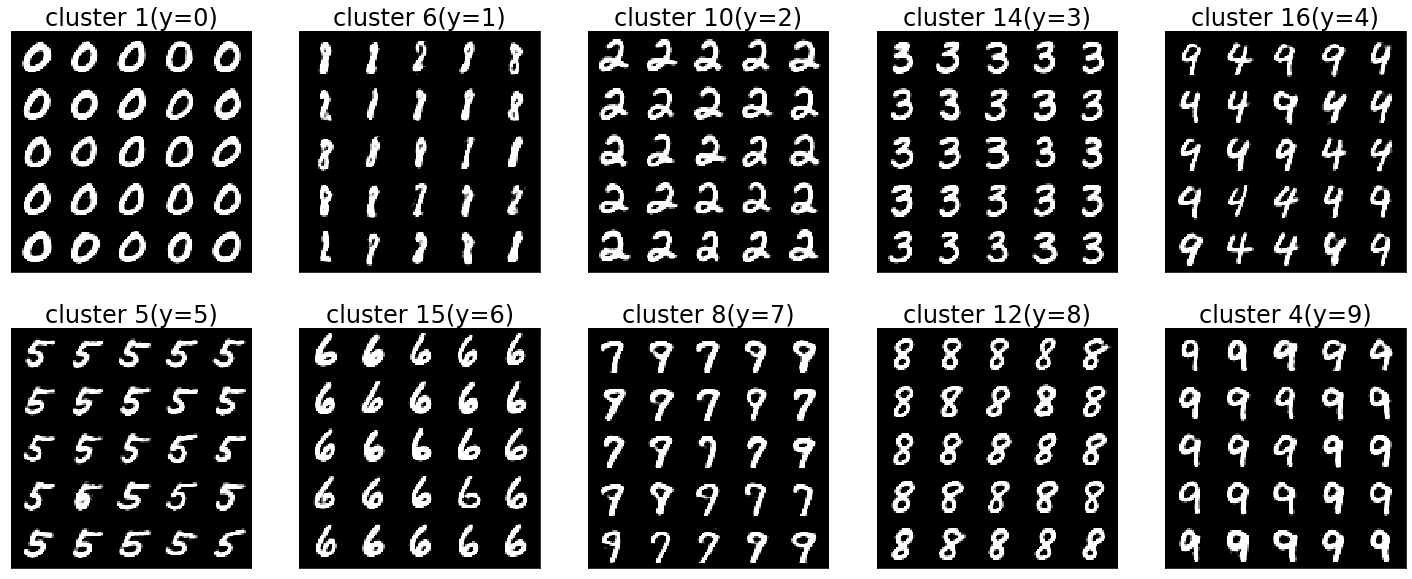

In [11]:
font = {'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2, 5, figsize=(5*5,5*2))
axs = axs.reshape(-1)
i=0
for label, (cid, flow_center) in c_selected:
    gen_cluster(axs[i], torch.FloatTensor(flow_center), ae_model, flow_model, _noise=0.2)
    axs[i].set_title(f'cluster {cid}(y={label})')
    i+=1
plt.subplots_adjust()
plt.savefig('mnist_gen_flow.eps', format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

## 3. TSNE

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

def hide_borders(ax):
    for d in 'top.bottom.left.right'.split('.'):
        ax.spines[d].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
def plot_2d_cluster(ax, z_tsne, y_tsne, mark='.', cmap_name='plasma', text=True, selected_labels=[]):  # tab10 viridis
    hide_borders(ax)
    
    labels, count = np.unique(y_tsne, return_counts=True)
    cmap = plt.get_cmap(cmap_name, len(labels))(range(len(labels)))
    vlabels = labels if len(selected_labels) == 0 else selected_labels
    for i, y in enumerate(vlabels):
        coord_y = z_tsne[y_tsne == y]
        ax.plot(coord_y[:, 0], coord_y[:, 1], mark, color=cmap[i])
        if text:
            center = np.median(coord_y, axis=0)
            ax.text(center[0], center[1], f'{labels[i]}({count[i]})', style='italic', 
                     bbox={'facecolor': 'white', 'alpha': 0.9, 'pad': 2.5})  # 'normal', 'italic', 'oblique'

In [13]:
tsne_data = []
for i, ds_name in enumerate(exp_info.keys()):
    Z, ds_ae = load_ae_dataset(ds_name, exp_info[ds_name].nsample, './saved_ae/mnist/mnist_ae_feat.pt')
    _, Y = ds_ae.data, ds_ae.targets

    N = 5000
    idx = np.random.choice(range(N), N)
    ae_tsne = TSNE(n_iter=500, random_state=1, init='random', early_exaggeration=12).fit_transform(Z[idx])
    tsne_data.append((ds_name, ae_tsne, Y[idx]))

start loading ae dataset
start loading ae dataset
start loading ae dataset
start loading ae dataset
tensor(4.1634)
tensor(13.0933)


In [14]:
flow_tsnes = []
N = 5000
for i in range(5):
    flow_ckpt = f'exp_out/mnist/full_mnist_mnist_N60000_E5_kappa0_0.005_a0_200_b0_100_alpha_0.001_20220212-175824_p23354/flow_E{i}.pt'
    flow_model.load_state_dict(torch.load(flow_ckpt))
    Z_flow = get_flow_repr(Z[:N], flow_model)
    flow_tsne = TSNE(n_iter=600, random_state=1, init='random', early_exaggeration=12).fit_transform(Z_flow[:N])
    flow_tsnes.append(flow_tsne)
    print(i)

0
1
2
3
4


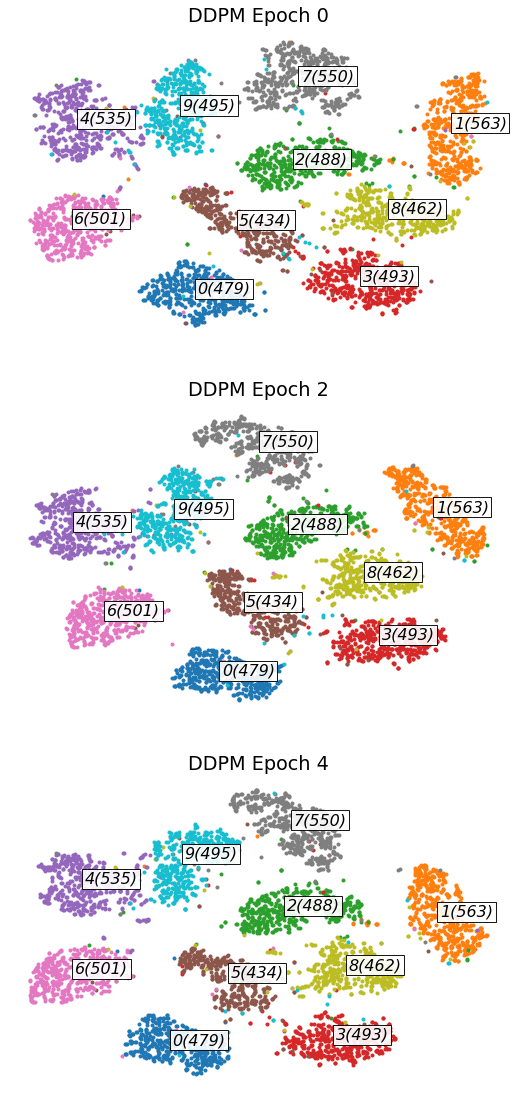

In [15]:
font = {'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)


nsub = 8
N = 5000
y = Y[:5000]
fig, axs = plt.subplots(3, 1, figsize=(9*1, 6.5*3))
axs = axs.reshape(-1)
for i, idx in enumerate([0, 2, 4]):
    flow_tsne = flow_tsnes[idx]
    plot_2d_cluster(axs[i], flow_tsne, y[:N], '.', 'tab10', text=True, selected_labels=[])
    axs[i].set_title(f'DDPM Epoch {idx}')
    
plt.subplots_adjust()
plt.savefig('tsne_mnist_flow2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [16]:
print(df_dict.keys())

dict_keys(['mnist', 'VaDE_har', 'VaDE_reuters10k', 'VaDE_stl'])


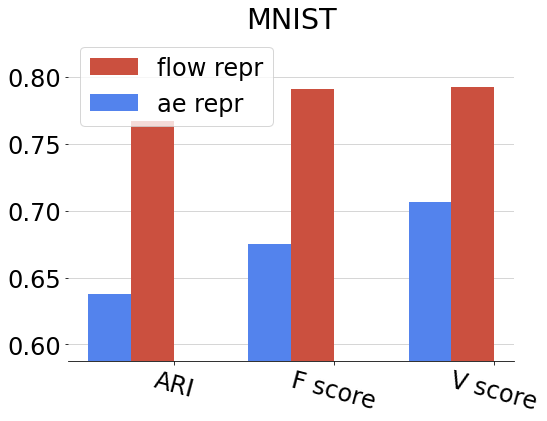

In [17]:
cmap = ['#CB503F', '#5383ED']

import numpy as np
import matplotlib.pyplot as plt

font = {'weight' : 'normal',
        'size'   : 24}
matplotlib.rc('font', **font)

algs = ['10-means+mnist']
alg_stick = ['MNIST']
mcs=['ARI', 'F score', 'V score']
fig, axs = plt.subplots(1, 1, figsize=(8*1, 6*1))
axs = [axs]
for i, alg in enumerate(algs):
    x_labels = mcs
    
    ae = [df_dict[alg.split('+')[-1]][f'{alg} ae repr'].loc[metric] for metric in mcs]
    flow = [df_dict[alg.split('+')[-1]][f'{alg} flow repr'].loc[metric] for metric in mcs] 
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].yaxis.grid(True, color='#cccccc', zorder=0)
    
    x_axis = np.arange(len(x_labels))*1.5
    axs[i].bar(x_axis+0.2, flow, 0.4, color=cmap[0], label = 'flow repr', zorder=3)
    axs[i].bar(x_axis-0.2, ae, 0.4, color=cmap[1], label = 'ae repr', zorder=3) 
    axs[i].set_xticks(x_axis+0.4)
    axs[i].set_xticklabels(mcs, rotation=-15)
    axs[i].set_ylim(bottom=np.asarray(ae).min()-0.05) 
    axs[i].set_title(alg_stick[i])
    axs[i].legend()
plt.subplots_adjust()
plt.savefig(f'flow_advance_mnist_h.pdf', bbox_inches='tight', pad_inches=0)

plt.show()